## 📥 Load Dataset and Filter for West Bengal

We start by loading the CSV file containing pincode and geographical data. Then, we filter only the rows where `StateName` is `WEST BENGAL` to limit our analysis to that region.


In [67]:
import pandas as pd

data = pd.read_csv('clustering_data.csv', dtype={'Latitude': str, 'Longitude': str})
STATE = "WEST BENGAL"
dataFiltered = data[data['StateName'] == STATE].copy()

print("Filtered shape for West Bengal:", dataFiltered.shape)

Filtered shape for West Bengal: (8775, 11)


## 🧹 Data Cleaning - Drop Duplicates and Missing Coordinates

We remove any duplicate rows and also drop entries where the latitude or longitude is missing or invalid (e.g., 0.0 or NaN). This ensures the clustering is based on valid and unique coordinates.

## 🧭 Remove Outliers Based on Latitude and Longitude Bounds

After plotting the initial map, we observe some points are far from West Bengal. We remove all data points that lie outside the bounding box defined by the min and max latitude and longitude of valid entries.


In [68]:
dataFiltered['Latitude'] = pd.to_numeric(dataFiltered['Latitude'], errors='coerce')
dataFiltered['Longitude'] = pd.to_numeric(dataFiltered['Longitude'], errors='coerce')

dataFiltered.dropna(subset=['Latitude', 'Longitude'], inplace=True)
dataFiltered.drop_duplicates(subset=['Pincode', 'Latitude', 'Longitude'], inplace=True)

print("Cleaned data shape:", dataFiltered.shape)

min_lat, max_lat = 21.5, 27.5
min_lon, max_lon = 85.0, 89.9

# Filter based on lat-lon bounds
dataFiltered = dataFiltered[
    (dataFiltered['Latitude'] >= min_lat) & (dataFiltered['Latitude'] <= max_lat) &
    (dataFiltered['Longitude'] >= min_lon) & (dataFiltered['Longitude'] <= max_lon)
]

Cleaned data shape: (6654, 11)


## 🗺️ Visualize Pincode Locations on Map of West Bengal

We use Cartopy and Matplotlib to visualize all valid pincode locations as a scatter plot over a map of India and West Bengal. This gives a good visual sense of the spatial distribution before clustering.


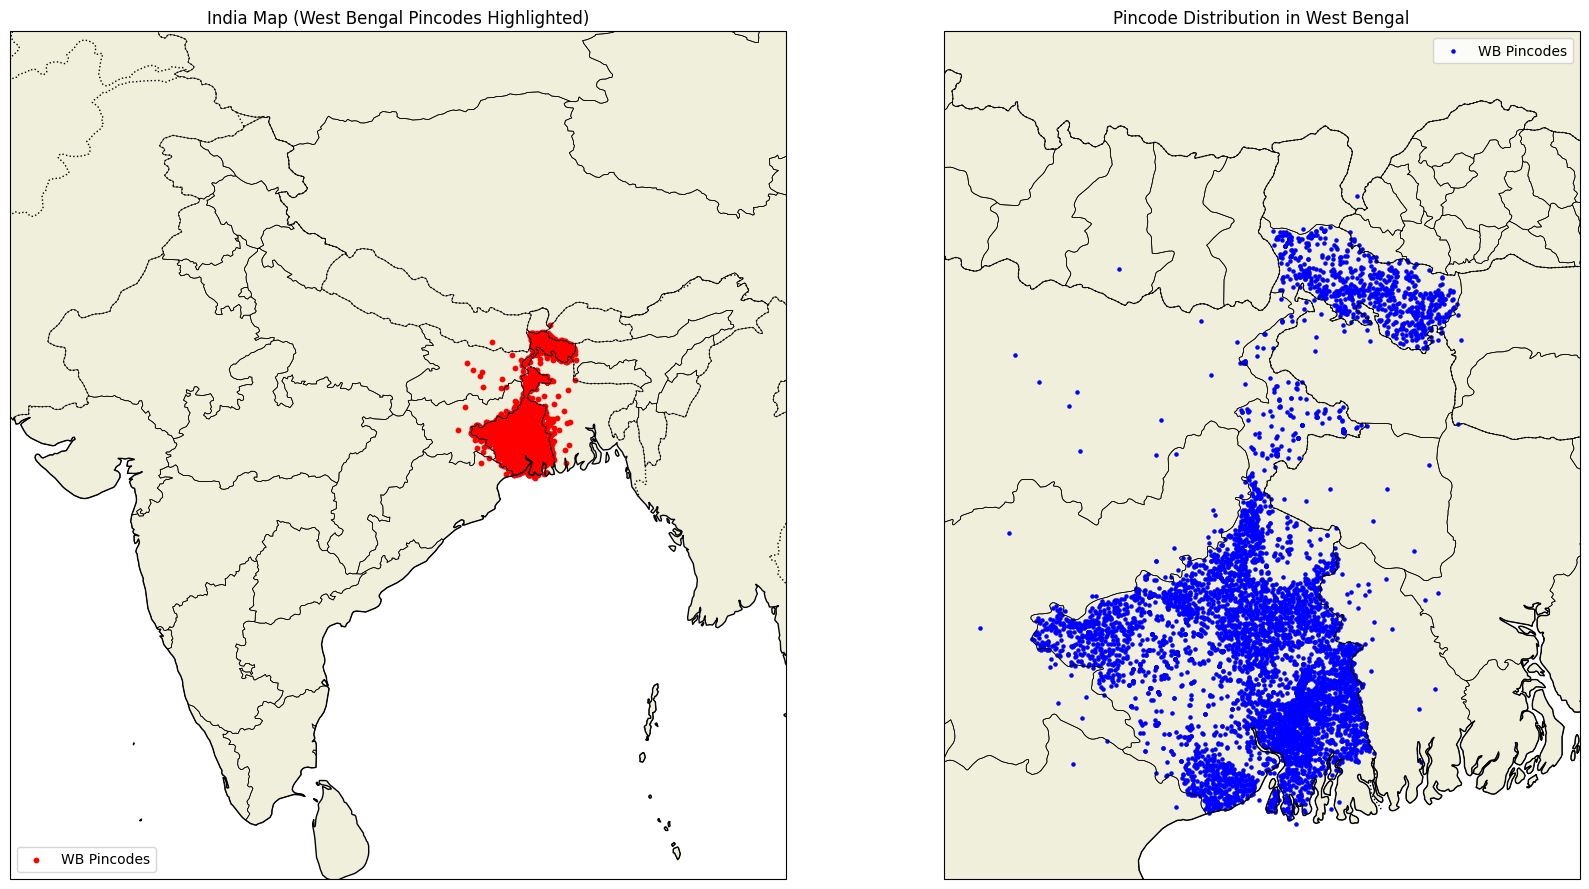

In [69]:
!pip install cartopy

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features (land, borders, coastlines)
ax1.set_title("India Map (West Bengal Pincodes Highlighted)")
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.STATES, linewidth=0.5)
ax1.set_extent([68, 98, 6, 38])

# Plot the pincode points
ax1.scatter(dataFiltered['Longitude'], dataFiltered['Latitude'], color='red', s=10, label='WB Pincodes', transform=ccrs.PlateCarree())
ax1.legend(loc='lower left')

ax2.set_title("Zoomed-In View: West Bengal Pincodes")
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.STATES, linewidth=0.5)
ax2.set_extent([85, 91, 21, 29])

# Plot points for West Bengal
ax2.scatter(dataFiltered['Longitude'], dataFiltered['Latitude'], color='blue', s=5, label='WB Pincodes', transform=ccrs.PlateCarree())
ax2.legend(loc='lower left')

plt.title("Pincode Distribution in West Bengal")
plt.legend()
plt.tight_layout()
plt.show()

## ⚖️ Normalize Latitude and Longitude

Before running k-means, we normalize the `Latitude` and `Longitude` columns using z-score normalization. This ensures both features contribute equally to distance calculations.


In [70]:
meanLongitude = dataFiltered['Longitude'].mean()
meanLatitude = dataFiltered['Latitude'].mean()

stdLongitude = dataFiltered['Longitude'].std()
stdLatitude = dataFiltered['Latitude'].std()

dataFilteredNormalized = dataFiltered.copy()

dataFilteredNormalized['Latitude'] = (dataFiltered['Latitude'] - meanLatitude) / stdLatitude
dataFilteredNormalized['Longitude'] = (dataFiltered['Longitude'] - meanLongitude) / stdLongitude

print("Normalized data shape:", dataFilteredNormalized.shape)

Normalized data shape: (6467, 11)


## 🧮 Define Distance Function and Custom KMeans Algorithm

We define a distance function that calculates Euclidean distance between points using only the normalized Latitude and Longitude. Then, we implement our own version of KMeans from scratch:
- Randomly initialize centroids
- Assign points to nearest centroids
- Update centroids
- Repeat until convergence or max iterations


In [71]:
from math import e
import numpy as np

labelMap = {column: index for index,column in enumerate(dataFiltered)}

def distance(data, centroid):
  distances = []
  for i in data:
    distances.append(((i[labelMap['Longitude']] - centroid[0])**2 + (i[labelMap['Latitude']] - centroid[1])**2)**0.5)
  return distances

def kmeans(data, k, iterations=100, tolerance=1e-4):
  np.random.seed(9)
  centroids = data[np.random.choice(data.shape[0], k, replace=False)]
  centroids = centroids[:, [labelMap['Longitude'], labelMap['Latitude']]]

  for _ in range(iterations):

    distancesToCentroids = [distance(data, centroid) for centroid in centroids]

    distancesToPoints = np.array(distancesToCentroids).T

    labels = np.argmin(distancesToPoints, axis=1)

    updatedCentroids = []

    for clusterIndex in range(k):
      clusterPoints = data[labels == clusterIndex]
      clusterPoints = clusterPoints[:, [labelMap['Longitude'], labelMap['Latitude']]]

      if len(clusterPoints) > 0:
        updatedCentroid = np.mean(clusterPoints, axis=0)
      else:
        updatedCentroid = data[np.random.choice(data.shape[0])]
        updatedCentriod = updatedCentroid[:, [labelMap['Longitude'], labelMap['Latitude']]]

      updatedCentroids.append(updatedCentroid)

    updatedCentroids = np.array(updatedCentroids)

    centroidShift = np.linalg.norm(centroids - updatedCentroids)

    if np.max(centroidShift) <= tolerance:
      print(f"Converged after {_+1} iterations.")
      break

    centroids = updatedCentroids

  return centroids, labels


arrayData = dataFilteredNormalized.to_numpy()

centroids, labels = kmeans(arrayData, 5)

Converged after 29 iterations.


## 🎨 Plot Clusters on Map with Colors and Boundaries

Once clustering is complete, we plot the clusters using different colors for each one. We also draw soft dotted boundaries to visually separate them and help analyze the geographical cluster regions.


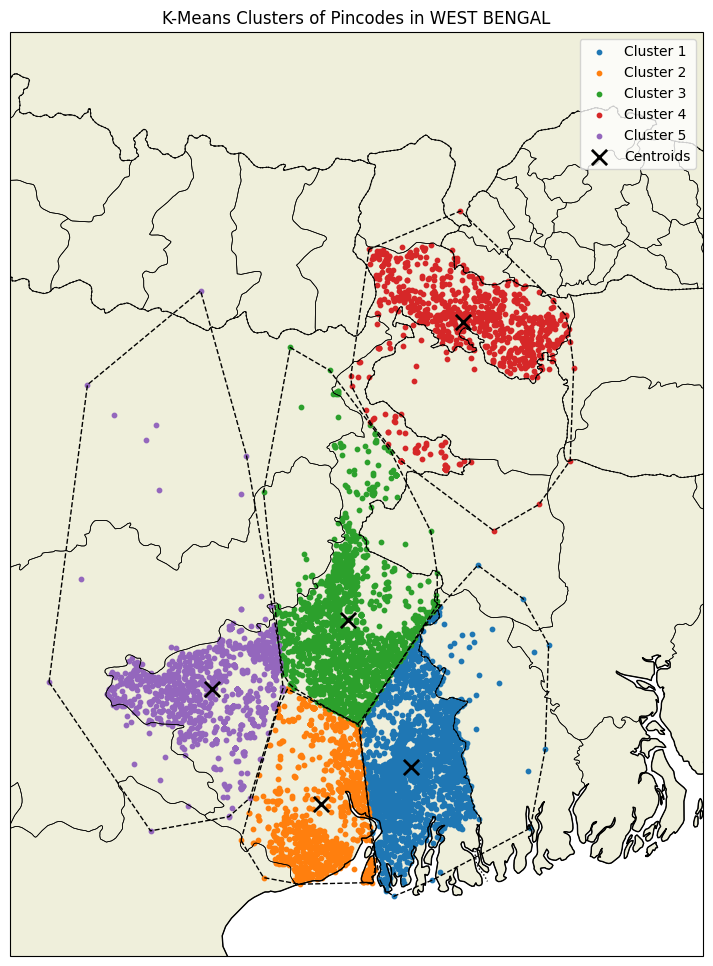

In [72]:
from scipy.spatial import ConvexHull

dataFiltered['Cluster'] = labels

def plotClusters(data, k, centroidList):

  fig = plt.figure(figsize=(12, 12))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.add_feature(cfeature.LAND)
  ax.add_feature(cfeature.BORDERS, linestyle=':')
  ax.add_feature(cfeature.COASTLINE)
  ax.add_feature(cfeature.STATES, linewidth=0.5)
  ax.set_extent([85, 91, 21, 29])

  cmap = plt.colormaps.get_cmap('tab10')
  colors = [cmap(i) for i in range(k)]

  for clusterIndex in range(k):
    clusterPoints = data[data['Cluster'] == clusterIndex]
    ax.scatter(
        clusterPoints['Longitude'],
        clusterPoints['Latitude'],
        label=f"Cluster {clusterIndex + 1}",
        s=10,
        color=colors[clusterIndex],
        transform=ccrs.PlateCarree()
    )

  centroidList = [[centroid[0] * stdLongitude + meanLongitude, centroid[1] * stdLatitude + meanLatitude] for centroid in centroidList]

  for index, centroid in enumerate(centroidList):
    ax.scatter(
        centroid[0], centroid[1],
        color='black',
        marker='x',
        s=120,
        linewidths=2,
        transform=ccrs.PlateCarree(),
        label=f"Centroids" if index == 0 else None
    )

  for clusterIndex in range(k):
    clusterPoints = data[data['Cluster'] == clusterIndex]
    clusterPoints = clusterPoints[['Longitude', 'Latitude']].to_numpy()

    if len(clusterPoints) >= 3:
      hull = ConvexHull(clusterPoints)
      hullPoints = clusterPoints[hull.vertices]

      ax.plot(
          *zip(*hullPoints, hullPoints[0]),
          color='black',
          linestyle='--',
          linewidth=1,
          transform=ccrs.PlateCarree()
      )

  ax.set_title(f'K-Means Clusters of Pincodes in {STATE}')
  plt.legend()
  plt.show()

plotClusters(dataFiltered, 5, centroids)

## 📉 Define Function to Compute WCSS (Within-Cluster Sum of Squares)

This function calculates the total squared distance between all points and their respective cluster centroids. WCSS is used as a measure of cluster compactness for each K.

## 🔁 Compute WCSS for Range of K Values

This function runs KMeans for a range of K values (e.g., 1 to 10), computes WCSS for each, and stores them. These values are used in the Elbow Method to determine the optimal number of clusters.


Computing WCSS for 1 clusters...
Converged after 2 iterations.
WCSS for 1 clusters: 7790.47


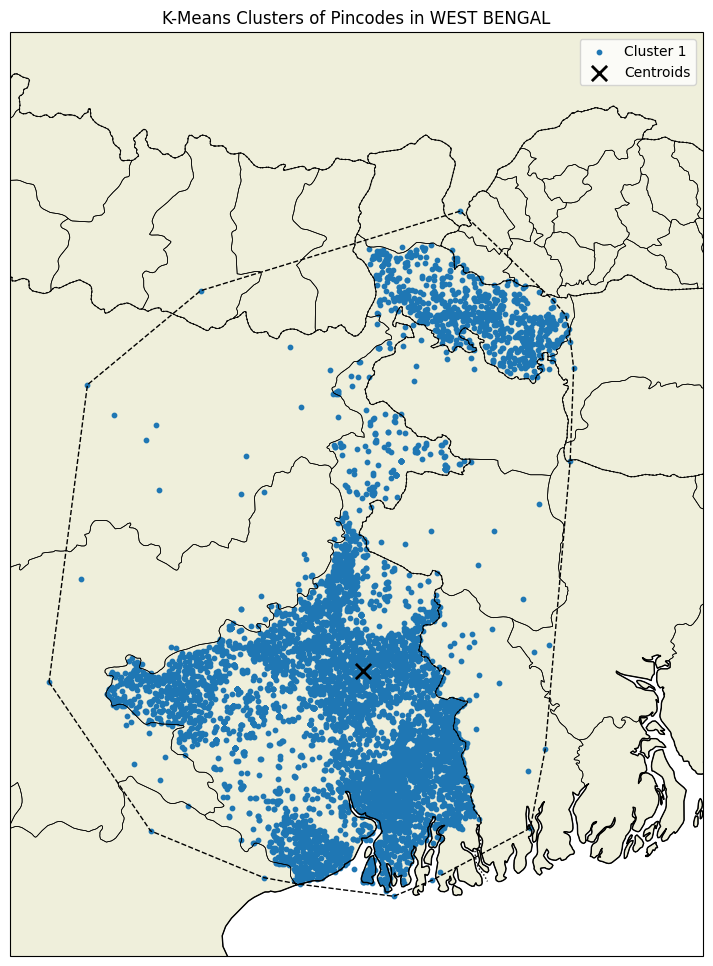

Computing WCSS for 2 clusters...
Converged after 15 iterations.
WCSS for 2 clusters: 6420.82


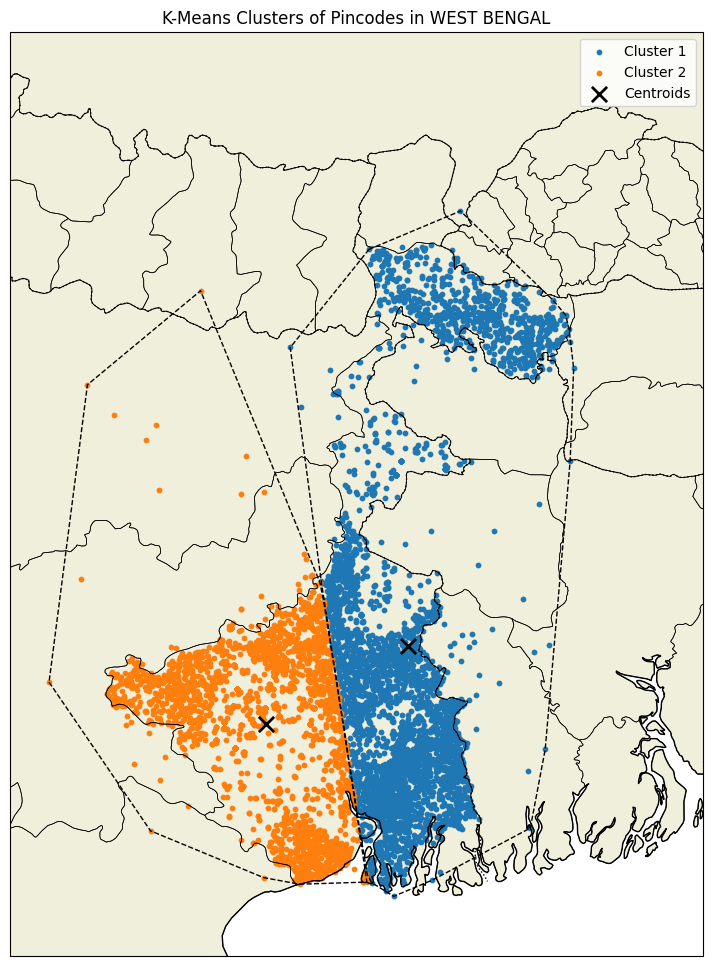

Computing WCSS for 3 clusters...
Converged after 18 iterations.
WCSS for 3 clusters: 4197.13


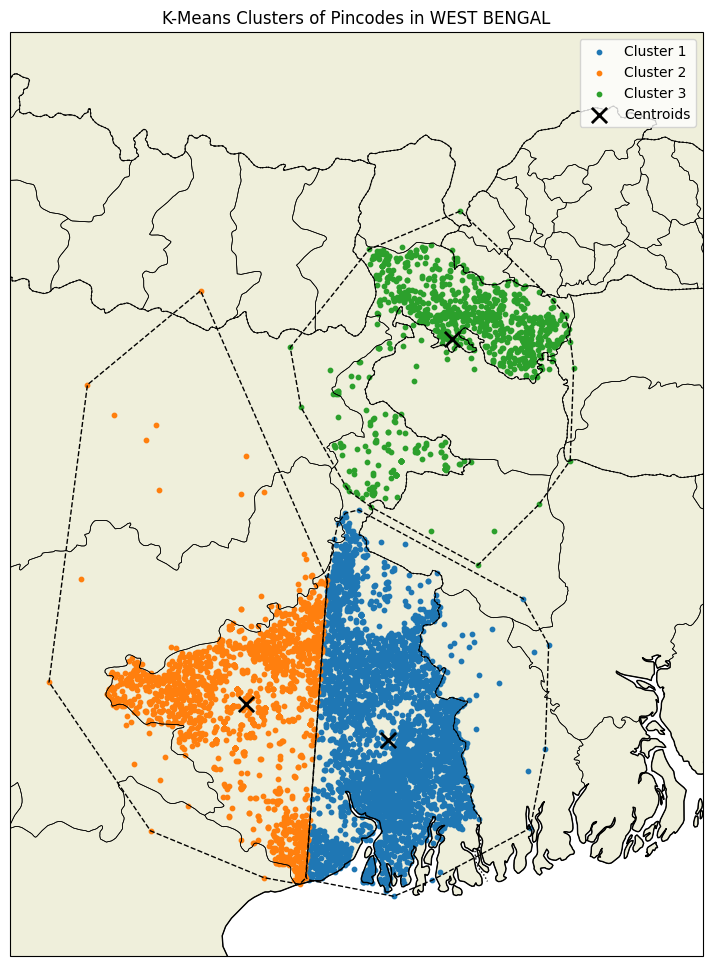

Computing WCSS for 4 clusters...
Converged after 24 iterations.
WCSS for 4 clusters: 3440.06


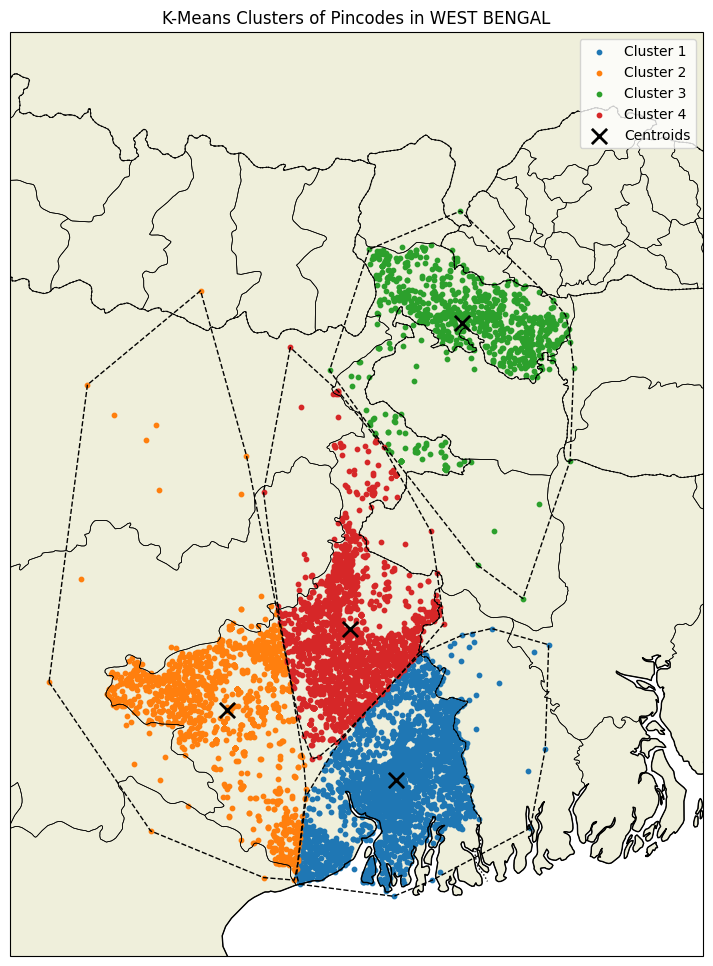

Computing WCSS for 5 clusters...
Converged after 29 iterations.
WCSS for 5 clusters: 3074.04


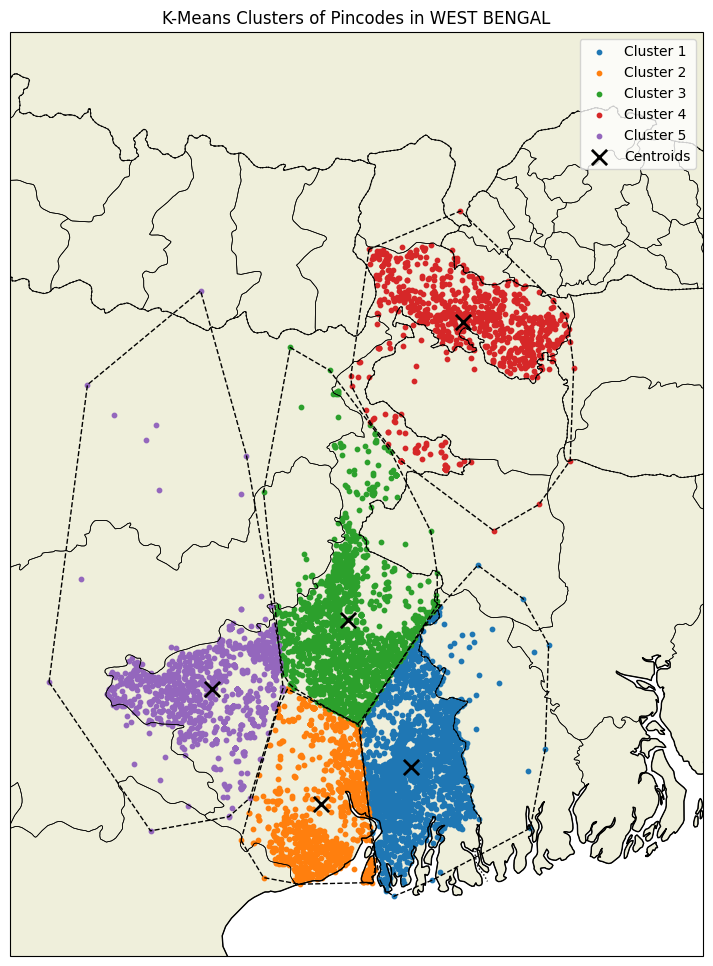

Computing WCSS for 6 clusters...
Converged after 25 iterations.
WCSS for 6 clusters: 2787.99


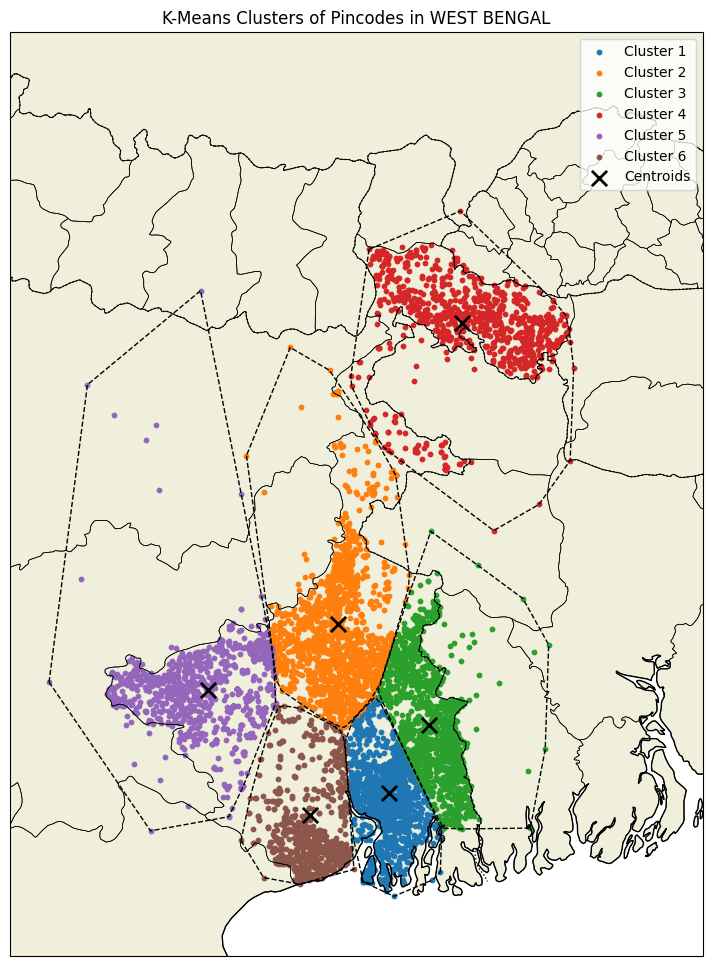

Computing WCSS for 7 clusters...
Converged after 31 iterations.
WCSS for 7 clusters: 2687.19


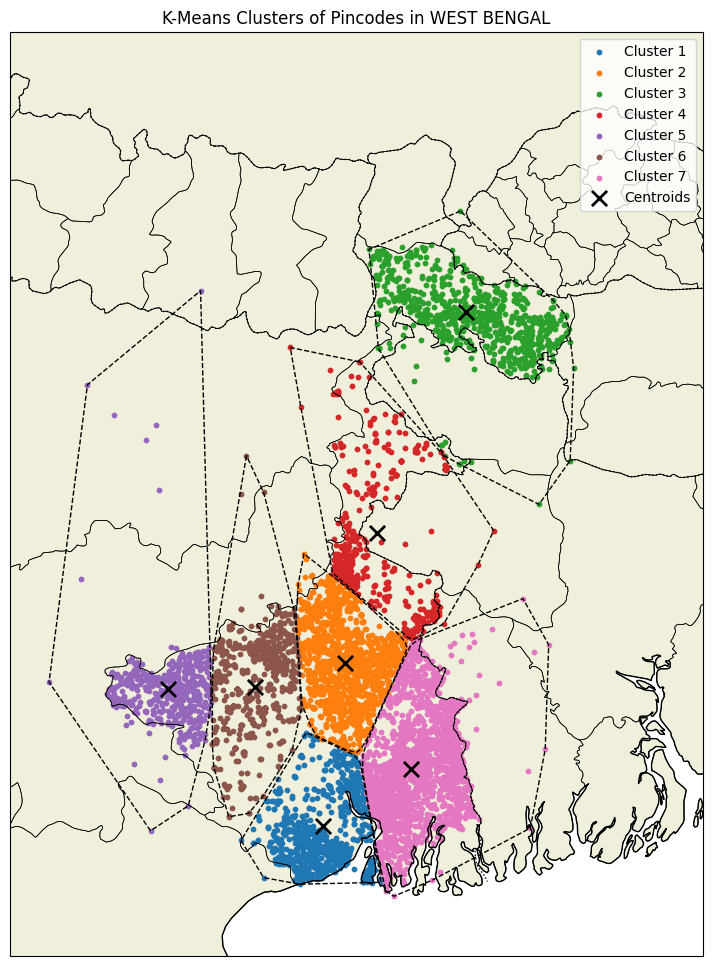

Computing WCSS for 8 clusters...
Converged after 28 iterations.
WCSS for 8 clusters: 2409.17


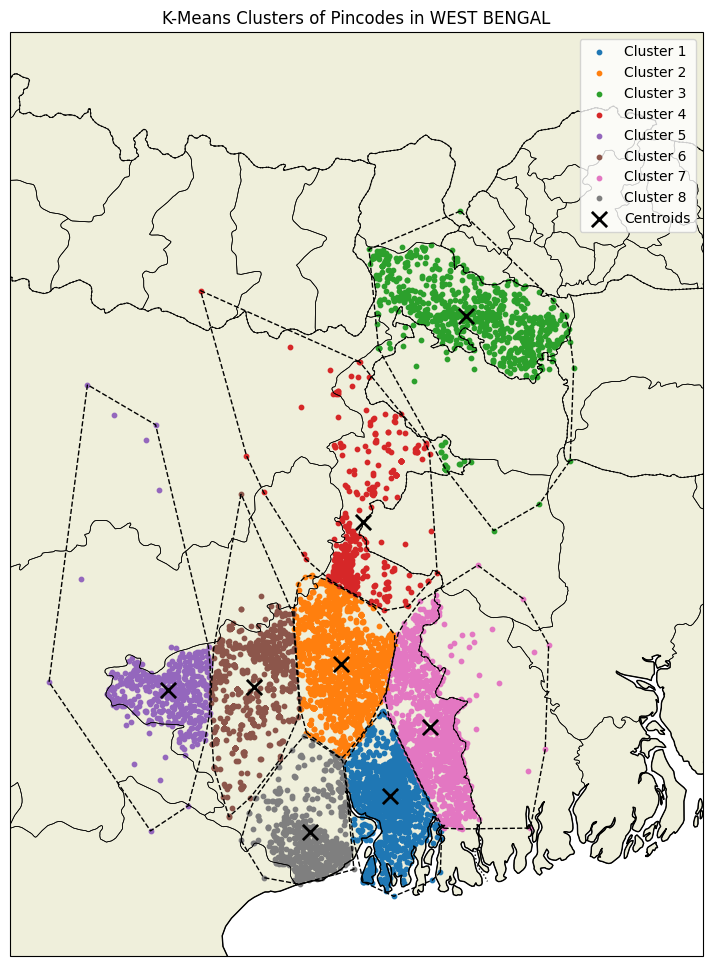

Computing WCSS for 9 clusters...
Converged after 42 iterations.
WCSS for 9 clusters: 2245.87


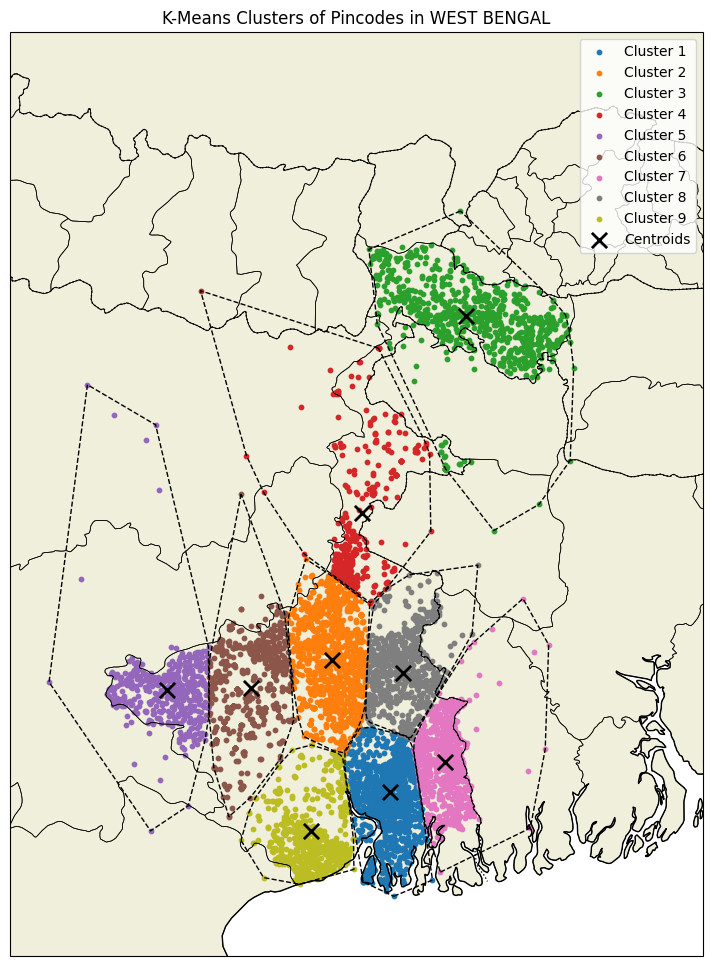

Computing WCSS for 10 clusters...
Converged after 38 iterations.
WCSS for 10 clusters: 2151.38


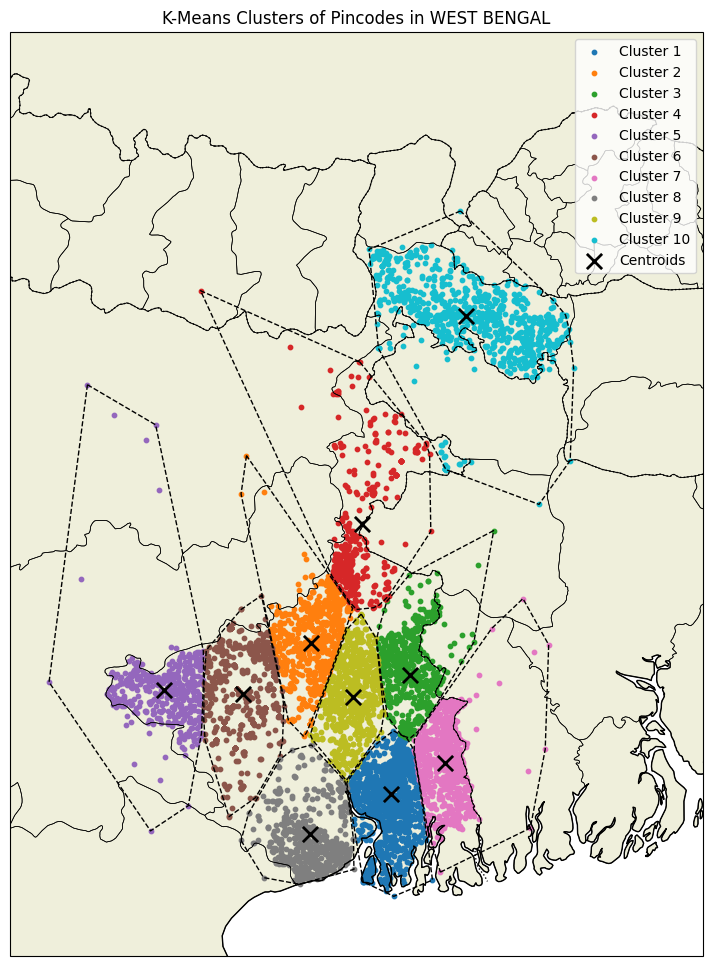

In [73]:
def computeWCSS(data, labels, centroids):
  score = 0
  for index, point in enumerate(data):
    centroid = centroids[labels[index]]
    score += ((point[labelMap['Longitude']] - centroid[0])**2 + (point[labelMap['Latitude']] - centroid[1])**2)**0.5
  return score

def computeWCSSRange(data, kMax, plot=True):
  WCSSScores = []
  for k in range(1, kMax+1):
    if plot:
      print(f"Computing WCSS for {k} clusters...")
    arrayData = dataFilteredNormalized.to_numpy()
    centroids, labels = kmeans(arrayData, k)
    dataFiltered['Cluster'] = labels
    score = computeWCSS(arrayData, labels, centroids)
    if plot:
      print(f"WCSS for {k} clusters: {score:.2f}")
    WCSSScores.append(score)
    if plot:
      plotClusters(dataFiltered, k, centroids)
  return WCSSScores

scores = computeWCSSRange(dataFiltered, 10)

## 📊 Elbow Method: Plot WCSS vs. K

We plot the WCSS scores against the number of clusters K. The elbow point in the graph indicates the optimal K where adding more clusters doesn't significantly reduce WCSS.


Converged after 2 iterations.
Converged after 15 iterations.
Converged after 18 iterations.
Converged after 24 iterations.
Converged after 29 iterations.
Converged after 25 iterations.
Converged after 31 iterations.
Converged after 28 iterations.
Converged after 42 iterations.
Converged after 38 iterations.


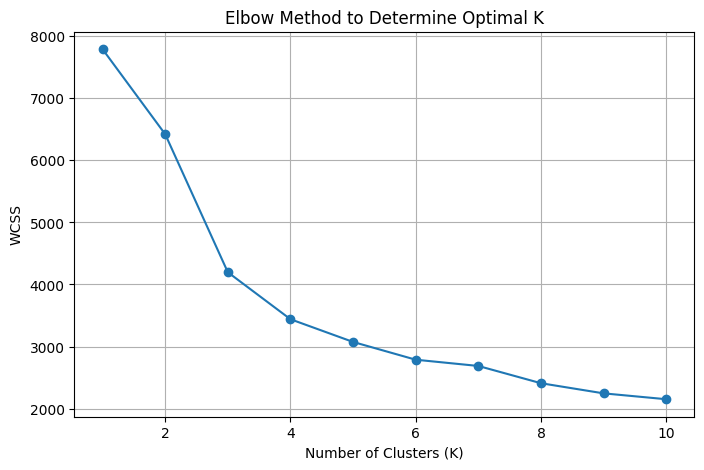

In [74]:
def plotWCSS(data, kMax):
  scores = computeWCSSRange(data, kMax, plot=False)
  plt.figure(figsize=(8, 5))
  plt.plot(range(1,kMax+1), scores, marker='o')
  plt.xlabel('Number of Clusters (K)')
  plt.ylabel('WCSS')
  plt.title('Elbow Method to Determine Optimal K')
  plt.grid(True)
  plt.show()

plotWCSS(dataFiltered, 10)

## 🔍 Automatically Detect Elbow Using Second Derivative

We calculate the second derivative (rate of change of WCSS drop) to find the point of maximum curvature (elbow point). This value is chosen as the optimal number of clusters.


In [79]:
def findElbowPoint(data, kMax):
  scores = computeWCSSRange(data, kMax, plot=False)
  elbow = 1
  maximumDrop = 0
  for k in range(2, kMax+1):
    if k == kMax:
      drop = (scores[k-2] - scores[k-1])
    else:
      drop = (scores[k-2] - scores[k-1]) - (scores[k-1] - scores[k])
    if drop > maximumDrop:
      maximumDrop = drop
      elbow = k
  return elbow

optimalK = findElbowPoint(dataFiltered, 10)
print("According to the Elbow method, the best K = ", optimalK)

Converged after 2 iterations.
Converged after 15 iterations.
Converged after 18 iterations.
Converged after 24 iterations.
Converged after 29 iterations.
Converged after 25 iterations.
Converged after 31 iterations.
Converged after 28 iterations.
Converged after 42 iterations.
Converged after 38 iterations.
According to the Elbow method, the best K =  3


## 🧠 Final Clustering Using Optimal K and Plotting Clusters

Using the optimal number of clusters determined from the Elbow Method, we:
- Run the KMeans algorithm one final time to get the final centroids and labels.
- Plot the clustered data points on the map of West Bengal.
- Color each cluster differently to visualize how geographical areas group together.
This plot represents the final clustering output and forms the basis for drawing inferences.


Converged after 18 iterations.


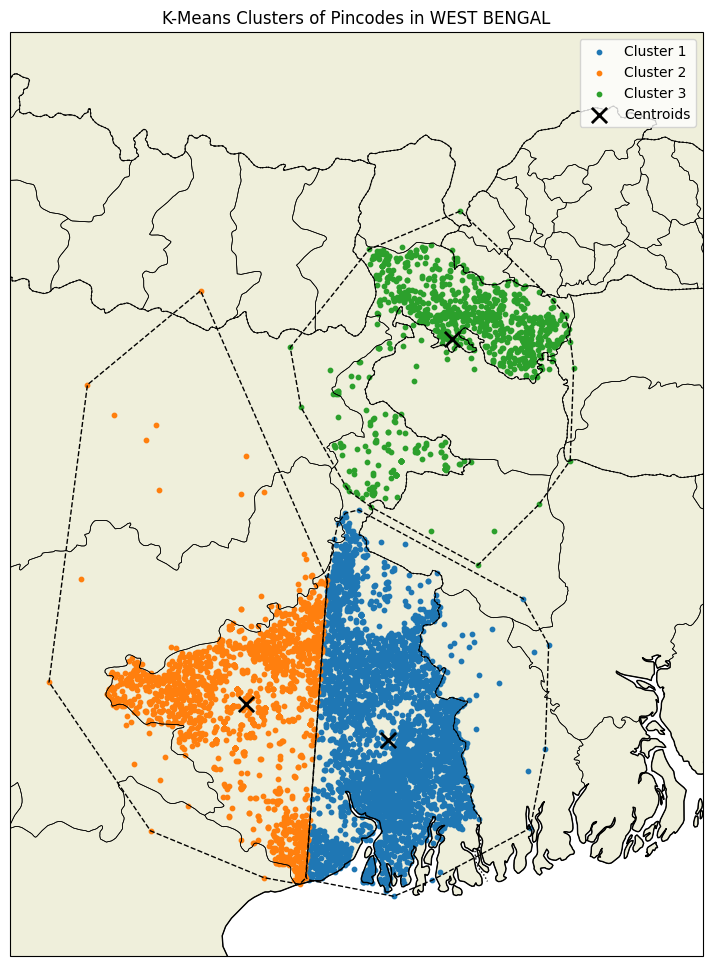

In [80]:
centroids, labels = kmeans(arrayData, optimalK)
dataFiltered['Cluster'] = labels
plotClusters(dataFiltered, optimalK, centroids)

## 📌 Inference and Insights from K-Means Clustering of West Bengal Pincodes

After performing KMeans clustering on the pincode locations across West Bengal, we observe three distinct clusters geographically segmented.

### 🔍 Key Observations:
- The **southeastern cluster** (in blue) roughly corresponds to the **Kolkata and surrounding regions**, indicating a **high density of pincodes**. This aligns with expectations due to the **urban concentration and population density** in and around Kolkata.
- The **western cluster** (in orange) covers parts of **southwestern districts** like Medinipur, which have a moderate spread of delivery locations.
- The **northern cluster** (in green) covers **northern districts of West Bengal**, such as Jalpaiguri, Cooch Behar, and surrounding areas, where there is again a significant but localized population.

### 🧠 Reason for Clustering Pattern:
The clustering pattern is likely influenced by **population density and urbanization**:
- Urban areas have **more delivery points (pincodes)** in close proximity, resulting in tighter clusters.
- Rural or sparsely populated areas are more **spread out**, leading to looser clusters.

### 🚀 Practical Implication:
- These clusters could help optimize **logistics**, **postal routing**, or **delivery planning** by grouping nearby pincodes.
- Authorities can focus on **infrastructure improvements** in dense areas and **enhance connectivity** in sparse clusters.

This geographical segmentation helps understand the structural layout of pincode distribution and can be leveraged for more efficient services.
